<a href="https://colab.research.google.com/github/guoclara/cv-style-transfer/blob/main/AdaIn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from skimage.io import imread
import tensorflow as tf
import matplotlib.pyplot as plt
import skimage.io as io
import numpy as np
from pycocotools.coco import COCO
import glob
from tqdm import tqdm
from time import sleep
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


# Hyperparameters

In [ ]:
_epochs = 1
_lr = 0.5
_optimzer = tf.keras.optimizers.Adam(learning_rate=_lr, beta_1=0.9, epsilon=1e-7)
_train_ratio = 0.8
_val_ratio = 0.1
_test_ratio = 0.1
_dataset_sz = 500
_sz = 256
_batch_sz = 8

assert _train_ratio + _val_ratio + _test_ratio == 1

# Model

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

def get_vgg_layers(layers, print_summary=False):
  input = [vgg.input]
  output = []
  for layer in layers:
    output.append(vgg.get_layer(layer).output)
    
  model = tf.keras.Model(input, output)
  if (print_summary):
     model.summary()
  return model

80142336/80134624 [==============================] - 0s 0us/step


In [ ]:
# up to block4_conv1
encoder_layers = [i.name for i in vgg.layers[:13]]
encoder = get_vgg_layers(encoder_layers, True)

# TODO: create the decoder
decoder = tf.keras.Sequential(
    [
    # tf.keras.layers.Conv2DTranspose(256, 3, activation='relu'),
    # tf.keras.layers.UpSampling2D(),
    # # add reflection padding?
    # tf.keras.layers.Conv2DTranspose(256, 3, activation='relu'),
    # tf.keras.layers.UpSampling2D(),
    # tf.keras.layers.Conv2DTranspose(256, 3, activation='relu'),
    # tf.keras.layers.UpSampling2D(),
    # tf.keras.layers.Conv2DTranspose(256, 3, activation='relu'),
    # tf.keras.layers.UpSampling2D(),
    # tf.keras.layers.Conv2DTranspose(128, 3, activation='relu'),
    # tf.keras.layers.UpSampling2D(),
    # tf.keras.layers.Conv2DTranspose(128, 3, activation='relu'),
    # tf.keras.layers.UpSampling2D(),
    # tf.keras.layers.Conv2DTranspose(64, 3, activation='relu'),
    # tf.keras.layers.UpSampling2D(),
    # tf.keras.layers.Conv2DTranspose(64, 3, activation='relu'),
    # tf.keras.layers.UpSampling2D(),
    # tf.keras.layers.Conv2DTranspose(3, 3, activation='relu')
     tf.keras.layers.Conv2DTranspose(16, 3, 2, padding="SAME", activation='relu', kernel_initializer='he_normal'),
     tf.keras.layers.Conv2DTranspose(32, 3, 2, padding="SAME", activation='relu', kernel_initializer='he_normal'),
     tf.keras.layers.Conv2DTranspose(3, 3, 2, padding="SAME", activation='relu', kernel_initializer='he_normal'),
     tf.keras.layers.Conv2D(3, 3, 1, padding="SAME", activation='relu')
    ]
)

loss_style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1']

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [ ]:
def adaIN(style, content):
  # calculate mean and variance for each instance (shape: batch sz x width x height x channels)
  content_mean, content_var = tf.nn.moments(content, axes=[1,2])
  style_mean, style_var = tf.nn.moments(style, axes=[1,2])

  # print("content_mean shape: {}".format(tf.shape(content_mean)))
  # print("style_mean shape: {}".format(tf.shape(style_mean)))

  epsilon = 1e-5
  content_std = tf.sqrt(content_var) + epsilon
  style_std = tf.sqrt(style_var)

  # print("content_std shape: {}".format(tf.shape(content_std)))
  # print("style_std shape: {}".format(tf.shape(style_std)))

  content_mean = tf.expand_dims(content_mean, 1)
  content_mean = tf.expand_dims(content_mean, 1)

  style_mean = tf.expand_dims(style_mean, 1)
  style_mean = tf.expand_dims(style_mean, 1)

  content_std = tf.expand_dims(content_std, 1)
  content_std = tf.expand_dims(content_std, 1)

  style_std = tf.expand_dims(style_std, 1)
  style_std = tf.expand_dims(style_std, 1)

  return style_std * (content - content_mean) / content_std + style_mean
  # content_mean, content_var = tf.nn.moments(content, axes=[0,1,2])
  # style_mean, style_var = tf.nn.moments(style, axes=[0,1,2])

  # # print("content_mean shape: {}".format(tf.shape(content_mean)))
  # # print("style_mean shape: {}".format(tf.shape(style_mean)))

  # norm_content = tf.nn.batch_normalization(content, content_mean, content_var, style_mean, tf.sqrt(style_var), 1e-3)

  # return norm_content

In [ ]:
class AdaINModel(tf.keras.models.Model):
  def __init__(self):
    super(AdaINModel, self).__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.adaIN = adaIN
    self.style_loss_model = get_vgg_layers(loss_style_layers)
    # TODO: hyperparameters to tune
    self.style_weight = 1e-2
    self.content_weight = 1

  def call(self, style_imgs, content_imgs, for_loss=False):
    # print("input style shape: {}".format(tf.shape(style_imgs)))
    # print("input content shape: {}".format(tf.shape(content_imgs)))
    # get inputs into expected form for vgg19

    # print("style images range: {}, {}".format(np.min(style_imgs), np.max(content_imgs)))

    style_imgs = tf.keras.applications.vgg19.preprocess_input(style_imgs)
    content_imgs = tf.keras.applications.vgg19.preprocess_input(content_imgs)
    style_encoded = self.encoder(style_imgs)
    content_encoded = self.encoder(content_imgs)
    # print("encoded style shape: {}".format(tf.shape(style_encoded[-1])))
    # print("encoded content shape: {}".format(tf.shape(content_encoded[-1])))
    
    normalized = self.adaIN(style_encoded[-1], content_encoded[-1])
    # print(normalized)

    # print("normalized shape: {}".format(tf.shape(normalized)))
    
    if for_loss:
      # just return result of adaIN for content loss
      return normalized
    else:  
      # return adaIN/content target, output image
      return normalized, self.decoder(normalized)

  def loss(self, output_imgs, style_imgs, adaIN_output):
    # content_output_features = self.call(style_imgs, output_imgs, True)
    # print("output_imgs shape: {}".format(tf.shape(output_imgs)))
    decoded_then_encoded = self.encoder(output_imgs)[-1]
    # print("encoded output_imgs shape: {}".format(tf.shape(decoded_then_encoded)))
    content_loss = tf.keras.losses.MSE(adaIN_output, decoded_then_encoded)

    # imgs shape: batch sz x height x width x channels
    style_reference_layers = self.style_loss_model(style_imgs)
    style_output_layers = self.style_loss_model(output_imgs)

    style_loss = 0
    # for each layer, calculate mse between mean and std of target img (style img) and current (model output)
    for i in range(len(style_reference_layers)):
      target = style_reference_layers[i]
      current = style_output_layers[i]

      target_mean, target_var = tf.nn.moments(target, axes=[1,2])
      current_mean, current_var = tf.nn.moments(current, axes=[1,2])

      mean_loss = tf.reduce_sum(tf.math.squared_difference(current_mean, target_mean))
      std_loss = tf.reduce_sum(tf.math.squared_difference(tf.sqrt(current_var), tf.sqrt(target_var)))
      
      style_loss += (mean_loss + std_loss) / float(tf.shape(current)[0])
      # style_loss += (mean_loss + std_loss)
    # for i in range(len(style_reference_layers)):
    #   target = style_reference_layers[i]
    #   current = style_output_layers[i]

    #   target_mean, target_var = tf.nn.moments(target, axes=[0,1,2])
    #   current_mean, current_var = tf.nn.moments(current, axes=[0,1,2])

    #   # print("target_mean shape: {}".format(tf.shape(target_mean)))
    #   # print("target_var shape: {}".format(tf.shape(target_var)))

    #   # print("current_mean shape: {}".format(tf.shape(current_mean)))
    #   # print("current_var shape: {}".format(tf.shape(current_var)))

    #   mean_loss = tf.reduce_sum(tf.math.squared_difference(current_mean, target_mean))
    #   std_loss = tf.reduce_sum(tf.math.squared_difference(tf.sqrt(current_var), tf.sqrt(target_var)))
      
    #   # style_loss += (mean_loss + std_loss) / float(tf.shape(current)[0])
    #   style_loss += (mean_loss + std_loss)

    # # content_loss = tf.reduce_mean(content_loss)
    # # style_loss = tf.reduce_mean(style_loss)
    print("\n content loss: {}, style loss: {}".format(tf.reduce_mean(content_loss).numpy(), tf.reduce_mean(style_loss).numpy()))
    return self.content_weight * content_loss + self.style_weight * style_loss

# Preprocessing

In [ ]:
def img_to_tensor(img_path):
  img = imread(img_path)
  img = tf.convert_to_tensor(img, dtype=tf.float32)
  # get img into expected format for vgg19
  return tf.expand_dims(img, 0)

def show_tensor_as_img(img):
  # clip data for imshow
  img = tf.squeeze(img)
  plt.figure()
  plt.imshow(img/255.0)
  plt.show()

In [ ]:
# LOAD TRAINING ARTWORKS
artworks_path = glob.glob('/content/drive/MyDrive/CV Final Project/training_artworks/*.jpg')
artworks_path = artworks_path[:_dataset_sz]
print("Total number of artworks: {} \n".format(len(artworks_path)))

# LOAD TRAINING CONTENT IMAGES
coco=COCO('/content/drive/MyDrive/CV Final Project/training_contents/image_info_test2017.json')
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
imgIds = coco.getImgIds()
content_ids = imgIds[:_dataset_sz]
print("Total number of content images: {}".format(len(content_ids)))

Total number of artworks: 500 

loading annotations into memory...
Done (t=0.61s)
creating index...
index created!
Total number of content images: 500


Example style iamge: 

/content/drive/MyDrive/CV Final Project/training_artworks/19256.jpg


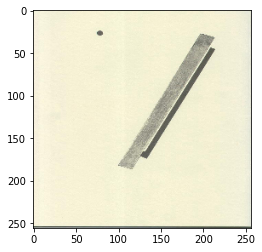

Example content image: 



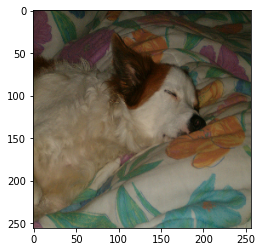

In [ ]:
rand_index = np.random.randint(0, _dataset_sz)
# rand_index = 347

print("Example style iamge: \n")
rand_style_img = artworks_path[rand_index]
print(rand_style_img)
# I = io.imread(rand_style_img)
tens = tf.image.resize(img_to_tensor(rand_style_img), (_sz, _sz))
show_tensor_as_img(tens)
# plt.axis('off')
# plt.imshow(I)
# plt.show()


print("Example content image: \n")
rand_content_img = coco.loadImgs(content_ids[rand_index])[0]
# I = io.imread(rand_content_img['coco_url'])
tens = tf.image.resize(img_to_tensor(rand_content_img['coco_url']), (_sz, _sz))
show_tensor_as_img(tens)
# plt.axis('off')
# plt.imshow(I)
# plt.show()

In [ ]:
# find all black and white images
# for i in range(len(artworks_path)):
#   if len(img_to_tensor(artworks_path[i]).shape) == 3:
#     print(artworks_path[i])


In [ ]:
# got rid of the image that triggered a warning
# for i in range(len(artworks_path)):
#   print(artworks_path[i])
#   if tf.shape(img_to_tensor(artworks_path[i]))[3] != 3:
#     print(artworks_path[i])

In [ ]:
def make_batch(start, end, style_img_paths, content_img_paths):
  batch_style_tensor = tf.zeros([1, _sz, _sz, 3], dtype=tf.float32)
  for i in range(start, end):
    batch_style_tensor = tf.concat([batch_style_tensor,
      tf.image.resize(img_to_tensor(style_img_paths[i]), (_sz, _sz))], axis=0)
  batch_style_tensor = batch_style_tensor[1:]

  batch_content_tensor = tf.zeros([1, _sz, _sz, 3], dtype=tf.float32)
  for i in range(start, end):
    batch_content_tensor = tf.concat([batch_content_tensor,
      tf.image.resize(img_to_tensor(coco.loadImgs(content_img_paths[i])[0]['coco_url']), (_sz, _sz))], axis=0)
  batch_content_tensor = batch_content_tensor[1:]

  return batch_style_tensor, batch_content_tensor

# Validation

In [ ]:
# TODO: write validation, use val at the end of each epoch in training loop

# Training

In [ ]:
# need to load in data bit by bit
def train(model, style_img_paths, content_img_paths):
  assert len(style_img_paths) == len(content_img_paths)
  epoch_losses = []
  for epch in range(2):
    random.shuffle(style_img_paths)
    random.shuffle(content_img_paths)
    print("TRAINING EPOCH {}".format(epch + 1))
    batch_losses = []

    for btch in tqdm(range(0, int(_dataset_sz/_batch_sz))):
      # if (min(btch + _batch_sz, _dataset_sz - btch) != _dataset_sz - btch):
      batch_style_tensor, batch_content_tensor = make_batch(btch,
        btch + _batch_sz, style_img_paths, content_img_paths)
      # show_tensor_as_img(batch_content_tensor[0])
      with tf.GradientTape() as tape:
        encoded_feature, generated_imgs = model.call(batch_style_tensor, batch_content_tensor, False)
        # print("generated imgs shape: {}".format(tf.shape(generated_imgs)))
        # print(generated_imgs[0])
        show_tensor_as_img(generated_imgs[0])
        loss = model.loss(generated_imgs, batch_style_tensor, encoded_feature)
        print("\n")
        # print(tf.reduce_mean(loss).numpy())
        batch_losses.append(loss)
      gradients = tape.gradient(loss, model.trainable_variables)
      _optimzer.apply_gradients(zip(gradients, model.trainable_variables))
    epoch_losses.append(np.mean(batch_losses))
    print("\nEpoch {} average loss: {}".format(epch + 1, np.mean(batch_losses)))
  return epoch_losses

# Testing

In [ ]:
def test(model, style_img_paths, content_img_paths):
  assert len(style_img_paths) == len(content_img_paths)
  # pick n combos
  n = 8
  style_img_paths = style_img_paths[:n]
  content_img_paths = content_img_paths[:n]

  gen_imgs = tf.zeros([1, _sz, _sz, 3], dtype=tf.float32)
  for btch in tqdm(range(0, len(style_img_paths), _batch_sz)):
    batch_style_tensor, batch_content_tensor = make_batch(btch, btch + _batch_sz, style_img_paths, content_img_paths)
    _, generated_imgs = model.call(batch_style_tensor, batch_content_tensor, False)
    gen_imgs = tf.concat([gen_imgs, generated_imgs], axis=0)
  gen_imgs = gen_imgs[1:]

  for i in range(n):
    show_tensor_as_img(gen_imgs[i])

# Run




  0%|          | 0/62 [00:00<?, ?it/s]

TRAINING EPOCH 1


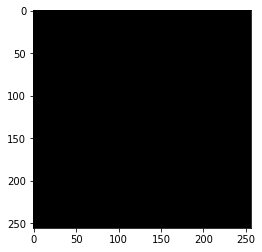


 content loss: 1232487.0, style loss: 896641472.0







  2%|▏         | 1/62 [00:06<06:46,  6.66s/it]

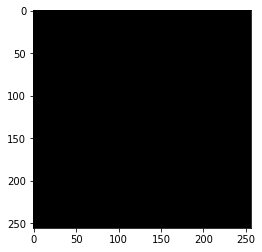


 content loss: 1189015.25, style loss: 870706560.0







  3%|▎         | 2/62 [00:11<06:09,  6.16s/it]

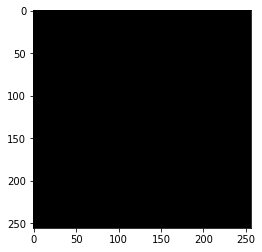


 content loss: 1271685.25, style loss: 942852992.0







  5%|▍         | 3/62 [00:16<05:39,  5.76s/it]

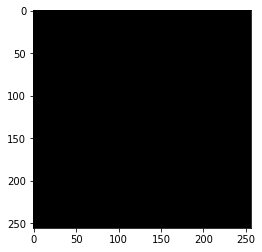


 content loss: 1285027.5, style loss: 931514112.0







  6%|▋         | 4/62 [00:21<05:13,  5.40s/it]

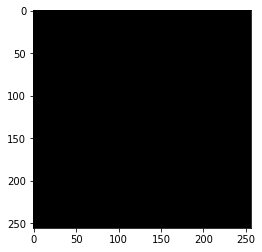


 content loss: 1302481.875, style loss: 939943424.0







  8%|▊         | 5/62 [00:25<04:48,  5.07s/it]

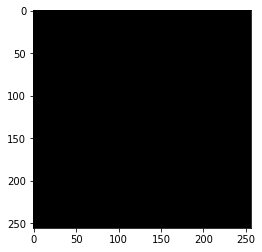


 content loss: 1330562.25, style loss: 959610432.0







 10%|▉         | 6/62 [00:29<04:30,  4.83s/it]

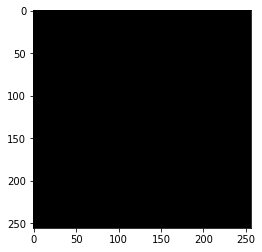


 content loss: 1324838.5, style loss: 917544960.0







 11%|█▏        | 7/62 [00:34<04:21,  4.76s/it]

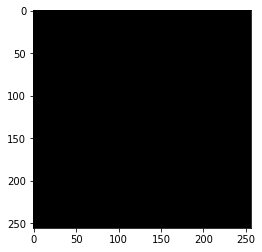


 content loss: 1034844.25, style loss: 739439936.0







 13%|█▎        | 8/62 [00:38<04:12,  4.67s/it]

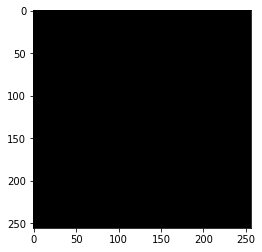


 content loss: 1062365.875, style loss: 770056896.0







 15%|█▍        | 9/62 [00:42<04:01,  4.55s/it]

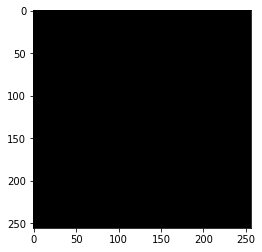


 content loss: 1018667.25, style loss: 705977344.0







 16%|█▌        | 10/62 [00:47<03:54,  4.51s/it]

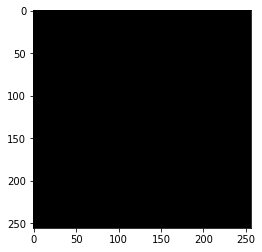


 content loss: 1026222.625, style loss: 681041344.0







 18%|█▊        | 11/62 [00:52<03:58,  4.68s/it]

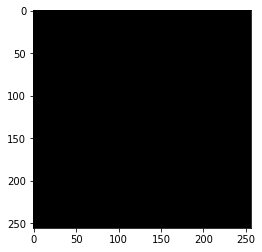


 content loss: 919262.5, style loss: 656204288.0







 19%|█▉        | 12/62 [00:57<03:57,  4.74s/it]

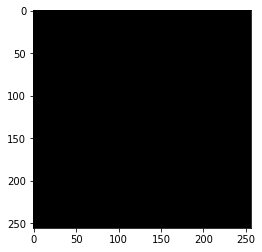


 content loss: 912429.25, style loss: 669653888.0







 21%|██        | 13/62 [01:02<03:54,  4.79s/it]

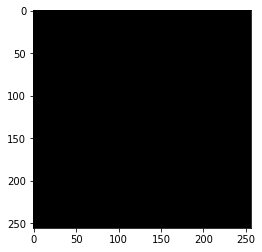


 content loss: 882647.625, style loss: 629090560.0







 23%|██▎       | 14/62 [01:07<03:51,  4.82s/it]

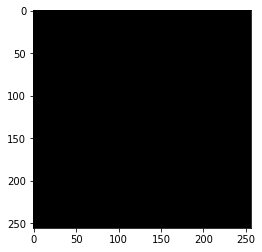


 content loss: 937831.5, style loss: 669315072.0







 24%|██▍       | 15/62 [01:12<03:48,  4.87s/it]

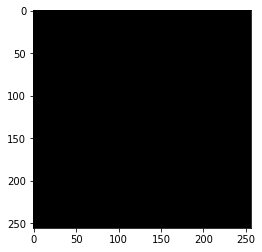


 content loss: 937258.4375, style loss: 669590656.0







 26%|██▌       | 16/62 [01:16<03:43,  4.85s/it]

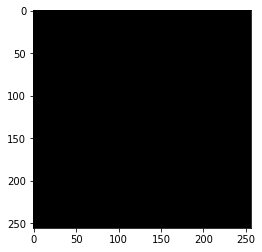


 content loss: 891250.75, style loss: 612461824.0







 27%|██▋       | 17/62 [01:21<03:40,  4.91s/it]

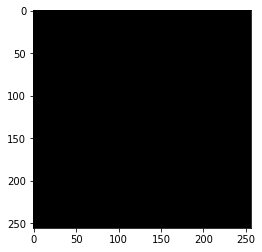


 content loss: 990113.625, style loss: 682195200.0







 29%|██▉       | 18/62 [01:27<03:38,  4.97s/it]

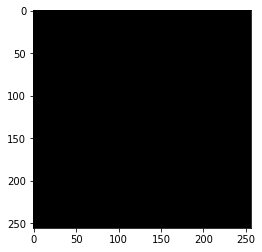


 content loss: 846233.125, style loss: 591569920.0







 31%|███       | 19/62 [01:31<03:29,  4.87s/it]

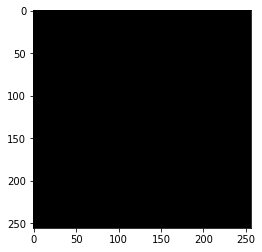


 content loss: 855263.25, style loss: 558653440.0







 32%|███▏      | 20/62 [01:36<03:23,  4.84s/it]

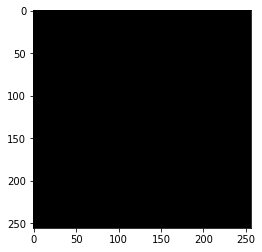


 content loss: 770608.8125, style loss: 519274688.0







 34%|███▍      | 21/62 [01:41<03:18,  4.83s/it]

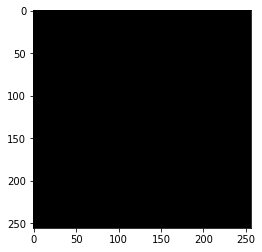


 content loss: 778101.4375, style loss: 547229440.0







 35%|███▌      | 22/62 [01:46<03:13,  4.84s/it]

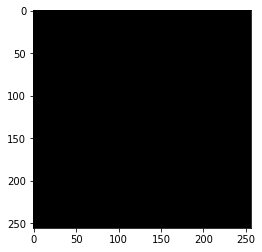


 content loss: 807336.125, style loss: 615338880.0







 37%|███▋      | 23/62 [01:50<03:07,  4.81s/it]

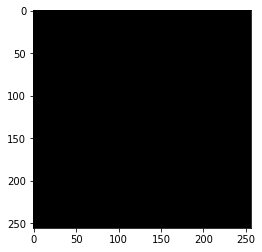


 content loss: 841088.875, style loss: 686862464.0







 39%|███▊      | 24/62 [01:55<03:02,  4.81s/it]

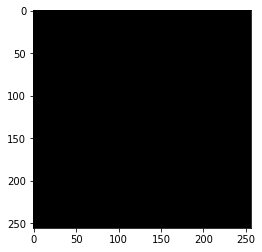


 content loss: 878275.9375, style loss: 706739584.0







 40%|████      | 25/62 [02:00<02:56,  4.78s/it]

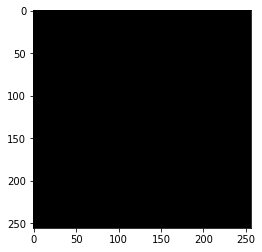


 content loss: 817965.25, style loss: 659394688.0







 42%|████▏     | 26/62 [02:05<02:54,  4.83s/it]

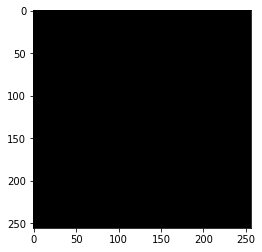


 content loss: 854114.5, style loss: 663737216.0







 44%|████▎     | 27/62 [02:09<02:46,  4.77s/it]

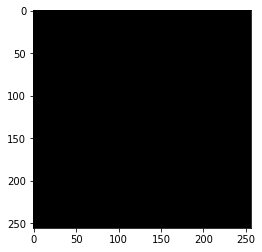


 content loss: 949205.375, style loss: 763111296.0







 45%|████▌     | 28/62 [02:14<02:41,  4.76s/it]

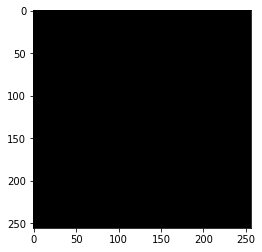


 content loss: 969700.4375, style loss: 759758080.0







 47%|████▋     | 29/62 [02:19<02:37,  4.78s/it]

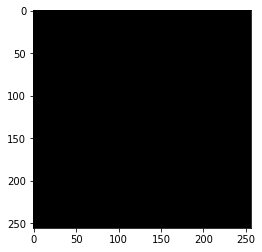


 content loss: 914940.375, style loss: 766349312.0







 48%|████▊     | 30/62 [02:24<02:31,  4.74s/it]

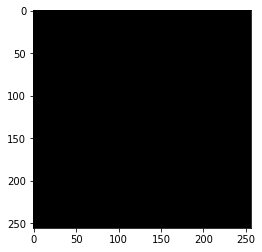


 content loss: 833504.375, style loss: 718620032.0







 50%|█████     | 31/62 [02:28<02:25,  4.71s/it]

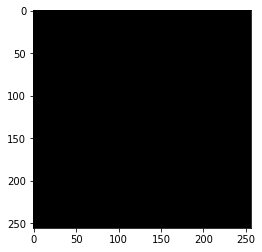


 content loss: 931217.125, style loss: 793343680.0







 52%|█████▏    | 32/62 [02:33<02:24,  4.82s/it]

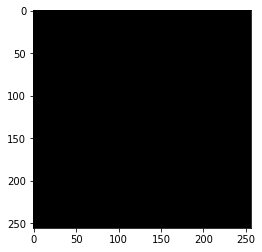


 content loss: 857609.6875, style loss: 753102080.0







 53%|█████▎    | 33/62 [02:38<02:17,  4.76s/it]

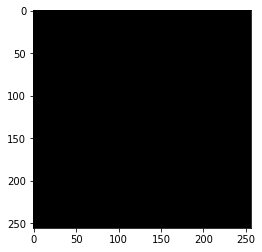


 content loss: 846632.5, style loss: 778990976.0







 55%|█████▍    | 34/62 [02:43<02:12,  4.74s/it]

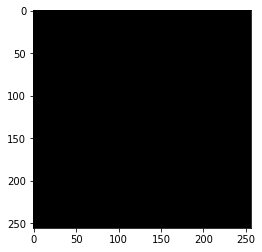


 content loss: 804846.25, style loss: 774116672.0







 56%|█████▋    | 35/62 [02:47<02:06,  4.68s/it]

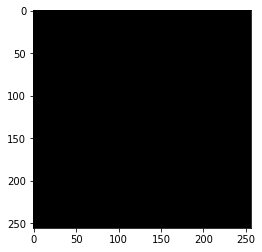


 content loss: 738279.0, style loss: 722737920.0







 58%|█████▊    | 36/62 [02:52<02:01,  4.68s/it]

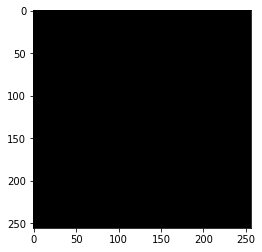


 content loss: 776921.0625, style loss: 754237312.0







 60%|█████▉    | 37/62 [02:56<01:55,  4.61s/it]

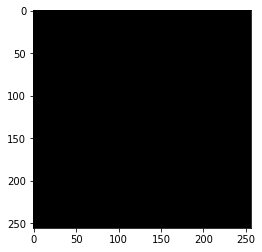


 content loss: 793057.5, style loss: 740485184.0







 61%|██████▏   | 38/62 [03:02<01:54,  4.78s/it]

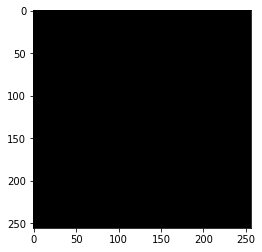


 content loss: 778464.875, style loss: 695969728.0







 63%|██████▎   | 39/62 [03:06<01:46,  4.63s/it]

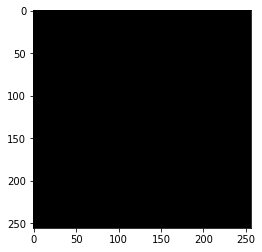


 content loss: 776458.0, style loss: 668238208.0







 65%|██████▍   | 40/62 [03:11<01:43,  4.68s/it]

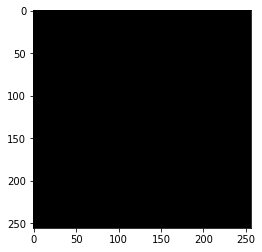


 content loss: 877821.375, style loss: 699866176.0







 66%|██████▌   | 41/62 [03:15<01:36,  4.61s/it]

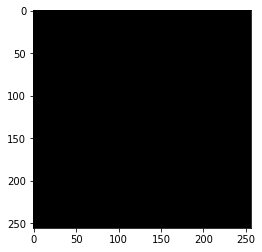


 content loss: 1155521.375, style loss: 918464832.0







 68%|██████▊   | 42/62 [03:20<01:36,  4.81s/it]

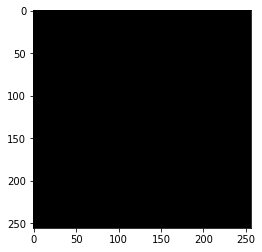


 content loss: 1166443.0, style loss: 889167168.0







 69%|██████▉   | 43/62 [03:25<01:30,  4.76s/it]

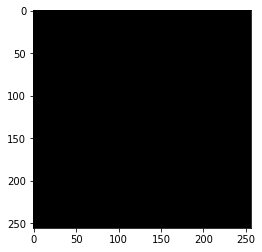


 content loss: 1120987.5, style loss: 881838720.0







 71%|███████   | 44/62 [03:30<01:25,  4.76s/it]

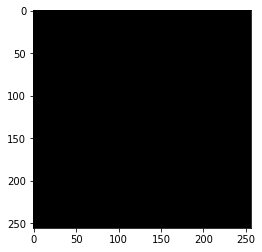


 content loss: 1046166.5625, style loss: 807555776.0







 73%|███████▎  | 45/62 [03:35<01:25,  5.04s/it]

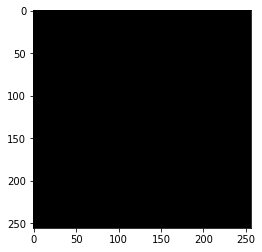


 content loss: 1094654.25, style loss: 788287616.0







 74%|███████▍  | 46/62 [03:40<01:19,  4.98s/it]

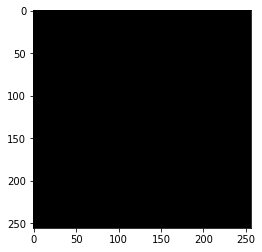


 content loss: 1132815.0, style loss: 843634880.0







 76%|███████▌  | 47/62 [03:45<01:14,  4.95s/it]

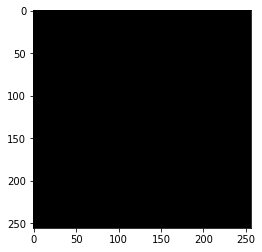


 content loss: 1088465.25, style loss: 781373440.0







 77%|███████▋  | 48/62 [03:50<01:08,  4.89s/it]

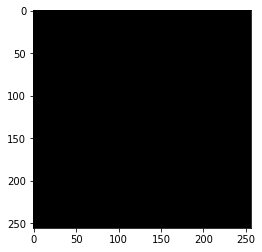


 content loss: 1036690.125, style loss: 822446208.0







 79%|███████▉  | 49/62 [03:55<01:03,  4.87s/it]

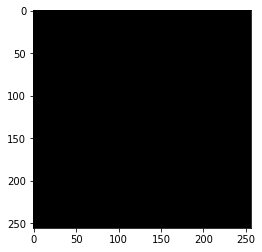


 content loss: 707620.3125, style loss: 570541824.0







 81%|████████  | 50/62 [03:59<00:57,  4.79s/it]

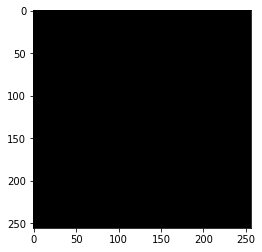


 content loss: 800749.3125, style loss: 668262016.0







 82%|████████▏ | 51/62 [04:04<00:52,  4.74s/it]

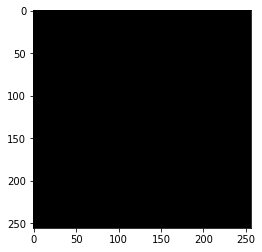


 content loss: 820239.125, style loss: 643236928.0







 84%|████████▍ | 52/62 [04:09<00:47,  4.78s/it]

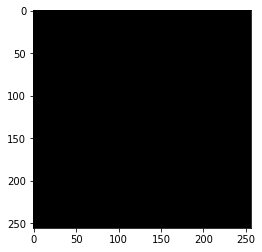


 content loss: 862356.25, style loss: 659629312.0







 85%|████████▌ | 53/62 [04:13<00:42,  4.67s/it]

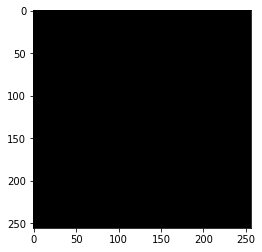


 content loss: 805873.875, style loss: 639508736.0







 87%|████████▋ | 54/62 [04:17<00:36,  4.54s/it]

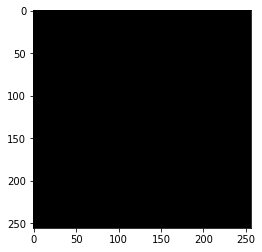


 content loss: 835045.3125, style loss: 608847488.0







 89%|████████▊ | 55/62 [04:22<00:31,  4.56s/it]

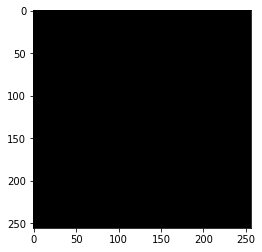


 content loss: 827724.625, style loss: 589518784.0







 90%|█████████ | 56/62 [04:28<00:29,  4.94s/it]

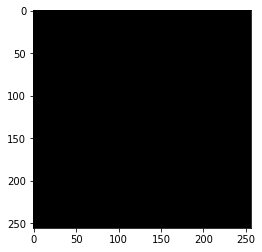


 content loss: 799895.0, style loss: 556363328.0







 92%|█████████▏| 57/62 [04:33<00:24,  4.99s/it]

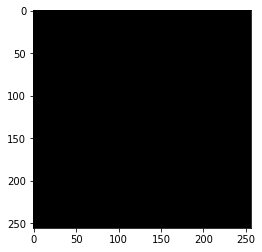


 content loss: 828909.0, style loss: 532502944.0







 94%|█████████▎| 58/62 [04:38<00:20,  5.06s/it]

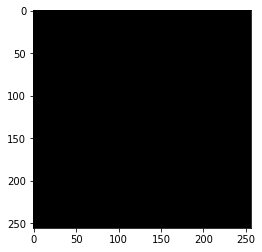


 content loss: 743017.5, style loss: 479273824.0







 95%|█████████▌| 59/62 [04:45<00:16,  5.43s/it]

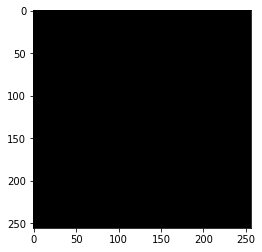


 content loss: 793762.375, style loss: 493906624.0







 97%|█████████▋| 60/62 [04:50<00:10,  5.40s/it]

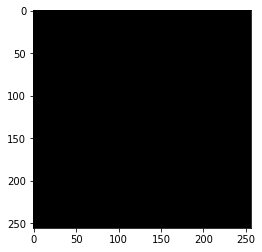


 content loss: 762396.625, style loss: 484079840.0







 98%|█████████▊| 61/62 [04:55<00:05,  5.41s/it]

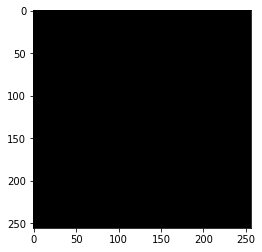


 content loss: 880314.375, style loss: 601609152.0







100%|██████████| 62/62 [05:00<00:00,  4.85s/it]



  0%|          | 0/62 [00:00<?, ?it/s]


Epoch 1 average loss: 8057620.0
TRAINING EPOCH 2


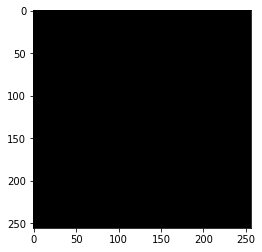


 content loss: 935251.75, style loss: 738382208.0







  2%|▏         | 1/62 [00:06<06:23,  6.29s/it]

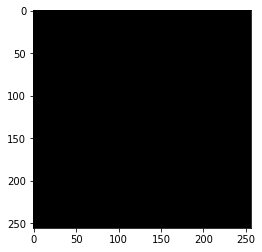


 content loss: 933888.8125, style loss: 740211712.0







  3%|▎         | 2/62 [00:10<05:40,  5.68s/it]

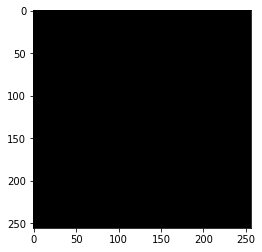


 content loss: 933618.125, style loss: 741444480.0







  5%|▍         | 3/62 [00:14<05:12,  5.30s/it]

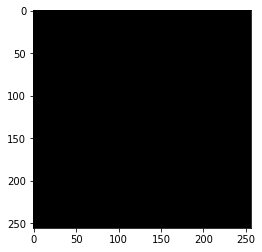


 content loss: 817203.125, style loss: 701766912.0







  6%|▋         | 4/62 [00:20<05:03,  5.24s/it]

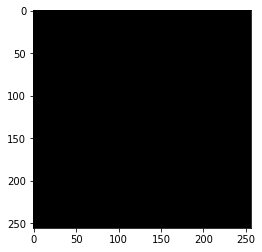


 content loss: 915864.25, style loss: 752721024.0







  8%|▊         | 5/62 [00:24<04:49,  5.08s/it]

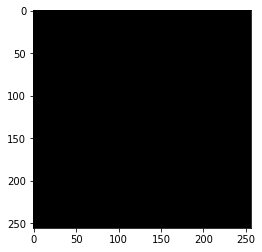


 content loss: 861744.6875, style loss: 717051520.0







 10%|▉         | 6/62 [00:30<04:48,  5.14s/it]

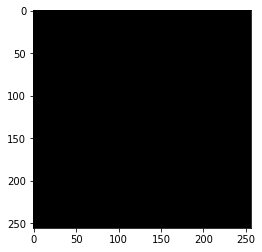


 content loss: 884480.25, style loss: 731495936.0







 11%|█▏        | 7/62 [00:35<04:43,  5.15s/it]

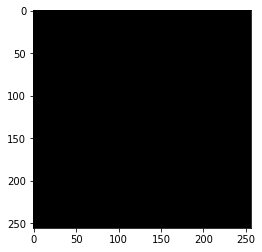


 content loss: 997362.4375, style loss: 811628800.0







 13%|█▎        | 8/62 [00:40<04:42,  5.24s/it]

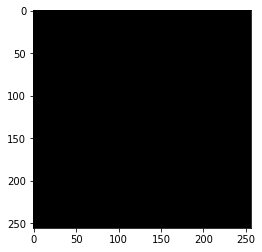


 content loss: 925973.0, style loss: 780330944.0







 15%|█▍        | 9/62 [00:46<04:48,  5.45s/it]

KeyboardInterrupt: ignored

In [ ]:
train_split_index = int(_dataset_sz * _train_ratio)
train_style_imgs = artworks_path[:train_split_index]
train_content_imgs = content_ids[:train_split_index]

val_split_index = int(_dataset_sz * _val_ratio)
val_style_imgs = artworks_path[train_split_index:train_split_index+val_split_index]
val_content_imgs = content_ids[train_split_index:train_split_index+val_split_index]

test_style_imgs = artworks_path[train_split_index+val_split_index:]
test_content_imgs = content_ids[train_split_index+val_split_index:]

model = AdaINModel()
epoch_loss = train(model, train_style_imgs, train_content_imgs)

plt.plot(epoch_loss, label = "Loss")
plt.xlabel('Epoch')
plt.legend()
plt.show()

test(model, test_style_imgs, test_content_imgs)